# Week 9-1: Unsupervised Machine Learning

## Bibliotheken importeren

In [1]:
import pandas as pd
import pyodbc
import math
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')

C:\Users\Will\AppData\Local\Temp\ipykernel_22228\2009978355.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data inlezen en kolommen selecteren

In [2]:
sales_conn = sqlite3.connect("../week 2/go_sales.sqlite")

order_header = pd.read_sql("SELECT * FROM order_header", sales_conn)
order_details = pd.read_sql("SELECT * FROM order_details", sales_conn)
product = pd.read_sql("SELECT * FROM product", sales_conn)
product_type = pd.read_sql("SELECT * FROM product_type", sales_conn)
product_line = pd.read_sql("SELECT * FROM product_line", sales_conn)
sales_branch = pd.read_sql("SELECT * FROM sales_branch", sales_conn)
country = pd.read_sql("SELECT * FROM country", sales_conn)

df = pd.merge(order_header, order_details, on="ORDER_NUMBER")
df = pd.merge(df, product, on="PRODUCT_NUMBER")
df = pd.merge(df, product_type, on="PRODUCT_TYPE_CODE")
df = pd.merge(df, product_line, on="PRODUCT_LINE_CODE")
df = pd.merge(df, sales_branch, on="SALES_BRANCH_CODE", suffixes=('_merged', '_product'))
df = pd.merge(df, country, on="COUNTRY_CODE")

df = df[['SALES_BRANCH_CODE', 'PRODUCT_LINE_CODE', 'COUNTRY']].drop_duplicates(subset=['SALES_BRANCH_CODE'])

df



,SALES_BRANCH_CODE,PRODUCT_LINE_CODE,COUNTRY
0,18,1,Canada
197,17,3,Canada
2604,13,1,Germany
3906,14,3,Germany
5167,23,5,France
5371,6,1,France
7520,24,1,Mexico
8899,19,1,United States
9309,21,3,United States
9767,22,3,United States


In [3]:
df = df.loc[:, ["PRODUCT_LINE_CODE", "COUNTRY", "SALES_BRANCH_CODE"]]
df

,PRODUCT_LINE_CODE,COUNTRY,SALES_BRANCH_CODE
0,1,Canada,18
197,3,Canada,17
2604,1,Germany,13
3906,3,Germany,14
5167,5,France,23
5371,1,France,6
7520,1,Mexico,24
8899,1,United States,19
9309,3,United States,21
9767,3,United States,22


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [4]:
dummies = pd.get_dummies(df.loc[:,["COUNTRY"]])
dummies

,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Belgium,COUNTRY_Brazil,COUNTRY_Canada,COUNTRY_China,COUNTRY_Finland,COUNTRY_France,COUNTRY_Germany,COUNTRY_Italy,COUNTRY_Japan,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
197,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2604,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3906,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5167,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5371,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7520,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
8899,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9309,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9767,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [5]:
df = pd.concat([df, dummies], axis = 1)
df = df.drop(["COUNTRY"], axis=1)
df

,PRODUCT_LINE_CODE,SALES_BRANCH_CODE,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Belgium,COUNTRY_Brazil,COUNTRY_Canada,COUNTRY_China,COUNTRY_Finland,COUNTRY_France,...,COUNTRY_Japan,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States
0,1,18,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
197,3,17,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2604,1,13,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3906,3,14,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5167,5,23,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5371,1,6,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7520,1,24,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8899,1,19,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9309,3,21,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
9767,3,22,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


## Clusteringmodel bouwen met 2 dimensies

In [6]:
df_2d = df.loc[:, ['PRODUCT_LINE_CODE', 'SALES_BRANCH_CODE']]
df_2d['PRODUCT_LINE_CODE'] = df_2d['PRODUCT_LINE_CODE'].astype(float)
df_2d['SALES_BRANCH_CODE'] = df_2d['SALES_BRANCH_CODE'].astype(float)
df_2d

,PRODUCT_LINE_CODE,SALES_BRANCH_CODE
0,1.0,18.0
197,3.0,17.0
2604,1.0,13.0
3906,3.0,14.0
5167,5.0,23.0
5371,1.0,6.0
7520,1.0,24.0
8899,1.0,19.0
9309,3.0,21.0
9767,3.0,22.0


In [7]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
kmeans.fit_predict(df_2d)

array([2, 2, 2, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 1, 3, 3, 1, 3, 1, 4, 1, 4,
       1, 2, 3, 1, 3, 3])

In [8]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,2.714286,22.000000
1,2.571429,29.857143
2,1.800000,15.400000
3,1.333333,36.500000
4,2.333333,7.333333


In [9]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,PRODUCT_LINE_CODE,SALES_BRANCH_CODE
0,2.714286,22.000000
1,2.571429,29.857143
2,1.800000,15.400000
3,1.333333,36.500000
4,2.333333,7.333333


In [16]:
for src_index, _ in df_2d.iterrows():
    euclidean_distances = {}
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidean_sum = 0

        for column_name in kmeans_centra.columns:
            # Ensure both values are numeric for subtraction
            value_from_df = pd.to_numeric(df_2d.at[src_index, column_name])
            value_from_centra = pd.to_numeric(kmeans_centra.at[centrumindex, column_name])
            
            current_difference = value_from_df - value_from_centra
            print(f'\t\t{value_from_df} - {value_from_centra} = {current_difference}')
            euclidean_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidean_sum}')
        euclidean_distance = math.sqrt(euclidean_sum)
        print(f'\tEuclidische afstand: {euclidean_distance}')
        euclidean_distances[centrumindex] = euclidean_distance
        print('------------------------------------------------')
    
    print(euclidean_distances)
    centrum_number = min(euclidean_distances, key=euclidean_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		1.0 - 2.7142857142857144 = -1.7142857142857144
		18.0 - 22.0 = -4.0
	Totale euclidische som: 18.93877551020408
	Euclidische afstand: 4.3518703462079475
------------------------------------------------
	Centrumindex 1:
		1.0 - 2.571428571428571 = -1.5714285714285712
		18.0 - 29.857142857142858 = -11.857142857142858
	Totale euclidische som: 143.06122448979593
	Euclidische afstand: 11.960820393676846
------------------------------------------------
	Centrumindex 2:
		1.0 - 1.8 = -0.8
		18.0 - 15.4 = 2.5999999999999996
	Totale euclidische som: 7.399999999999999
	Euclidische afstand: 2.7202941017470885
------------------------------------------------
	Centrumindex 3:
		1.0 - 1.3333333333333335 = -0.3333333333333335
		18.0 - 36.5 = -18.5
	Totale euclidische som: 342.3611111111111
	Euclidische afstand: 18.503002759312096
------------------------------------------------
	Centrumindex 4:
		1.0 - 2.3333333333333335 = -1.3333333333333335
		18.0 - 

,PRODUCT_LINE_CODE,SALES_BRANCH_CODE,Centrum
0,1.0,18.0,2.0
197,3.0,17.0,2.0
2604,1.0,13.0,2.0
3906,3.0,14.0,2.0
5167,5.0,23.0,0.0
5371,1.0,6.0,4.0
7520,1.0,24.0,0.0
8899,1.0,19.0,0.0
9309,3.0,21.0,0.0
9767,3.0,22.0,0.0


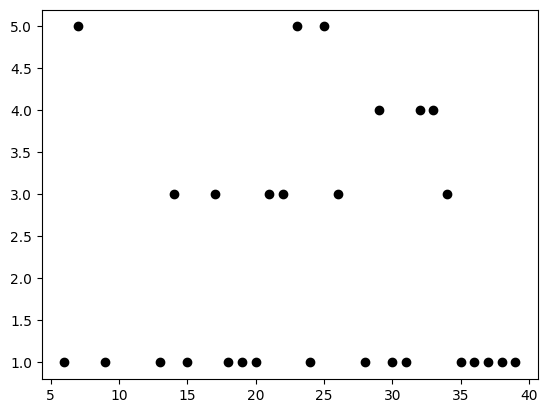

In [17]:
plt.scatter(df_2d['SALES_BRANCH_CODE'], df_2d['PRODUCT_LINE_CODE'], color = 'k')
plt.show()

In [18]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,7
1,7
2,5
3,6
4,3


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [26]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([2, 2, 2, 2, 0, 4, 0, 2, 2, 0, 2, 0, 0, 1, 3, 3, 1, 1, 1, 4, 1, 4,
       1, 2, 3, 1, 3, 3])

In [27]:
df['Centrum'] = prediction_results
df

,PRODUCT_LINE_CODE,SALES_BRANCH_CODE,COUNTRY_Australia,COUNTRY_Austria,COUNTRY_Belgium,COUNTRY_Brazil,COUNTRY_Canada,COUNTRY_China,COUNTRY_Finland,COUNTRY_France,...,COUNTRY_Korea,COUNTRY_Mexico,COUNTRY_Netherlands,COUNTRY_Spain,COUNTRY_Sweden,COUNTRY_Switzerland,COUNTRY_Taiwan,COUNTRY_United Kingdom,COUNTRY_United States,Centrum
0,1,18,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2
197,3,17,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2604,1,13,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3906,3,14,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
5167,5,23,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,0
5371,1,6,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,4
7520,1,24,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,0
8899,1,19,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,2
9309,3,21,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,2
9767,3,22,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0


### De juiste centra toewijzen aan rijen uit de dataset

In [22]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,5
1,7
2,3
3,5
4,3
5,5


## Evalueren

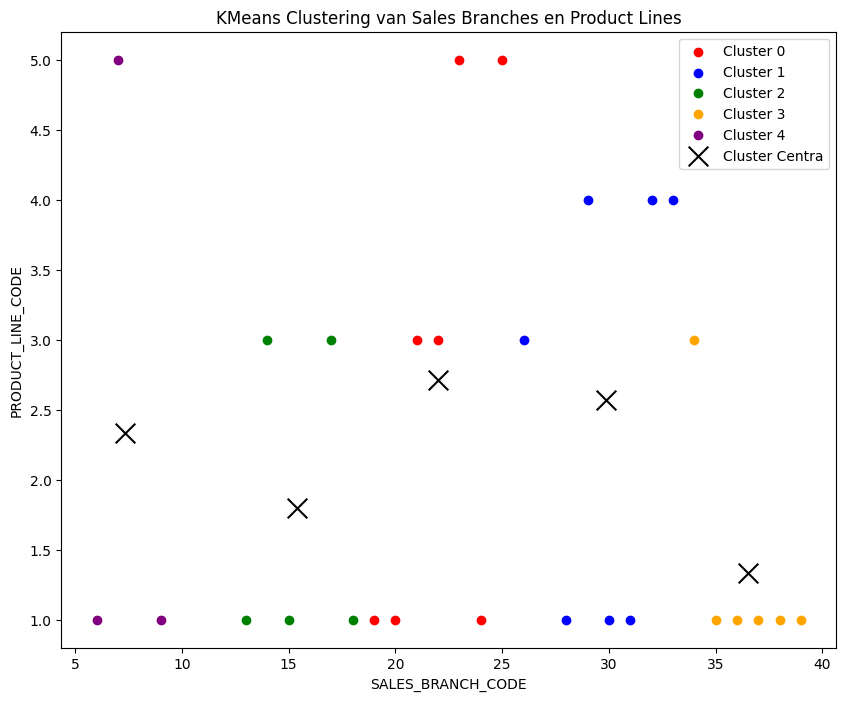

In [30]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_2d)

df_2d['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for cluster_label, color in zip(range(5), colors):
    cluster_data = df_2d[df_2d['Cluster'] == cluster_label]
    plt.scatter(cluster_data['SALES_BRANCH_CODE'], cluster_data['PRODUCT_LINE_CODE'], color=color, label=f'Cluster {cluster_label}')

centra = kmeans.cluster_centers_
plt.scatter(centra[:, 1], centra[:, 0], marker='x', s=200, color='black', label='Cluster Centra')

plt.xlabel('SALES_BRANCH_CODE')
plt.ylabel('PRODUCT_LINE_CODE')
plt.title('KMeans Clustering van Sales Branches en Product Lines')
plt.legend()

plt.show()